# ***Kaggle 기본 예제***
## 타이타닉 탑승자 데이터를 기반으로 생존자 예측해보기
### 필요한 모듈 import 및 데이터 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic_df = pd.read_csv('data/titanic_train.csv')
titanic_df.head()

FileNotFoundError: ignored

In [ ]:
# 데이터 정보 확인
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
'''
# 대략적인 컬럼 정보
 0   PassengerId  891 non-null    int64        -   탑승자 데이터 일련번호
 1   Survived     891 non-null    int64        -   생존여부 (0 : 사망, 1 : 생존)
 2   Pclass       891 non-null    int64        -   티켓의 선실 등급 (1 : 1등석, 2 : 2등석, 3 : 3등석)
 3   Name         891 non-null    object       -   탑승자 이름
 4   Sex          891 non-null    object       -   탑승자 성별
 5   Age          714 non-null    float64      -   탑승자 나이
 6   SibSp        891 non-null    int64        -   같이 탑승한 형제자매 또는 배우자 인원수
 7   Parch        891 non-null    int64        -   같이 탑승한 부모님 또는 어린이 인원수
 8   Ticket       891 non-null    object       -   티켓번호
 9   Fare         891 non-null    float64      -   요금
 10  Cabin        204 non-null    object       -   선실번호
 11  Embarked     889 non-null    object       -   중간 정착 항구(C : Cherbourg, Q : Queenstown, S : Southhampton)
'''

###  데이터 전처리 - Null 처리

In [ ]:
# 기본적으로 머신러닝 알고리즘은 null을 허용하지 않으므로 null 처리가 중요
# 컬럼의 상황과 데이터 상태를 고려하여 null 처리 - 채우기 처리

titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)         # Cabin 컬럼의 NaN값을 'N'문자로 채움
titanic_df['Embarked'].fillna('N', inplace=True)

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S


In [ ]:
# null 확인

titanic_df.isnull().sum()

# null값이 있으면 sum()자체가 수행될 수 없음

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### 데이터 탐색

In [ ]:
# 성별 분포

titanic_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
# 선실 분포

titanic_df['Cabin'].value_counts()

N              687
C23 C25 C27      4
B96 B98          4
G6               4
F33              3
              ... 
A10              1
B73              1
E38              1
C50              1
E10              1
Name: Cabin, Length: 148, dtype: int64

In [ ]:
# 중간정착 항구 분포

titanic_df['Embarked'].value_counts()

S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64

In [2]:
# 레이블 인코딩

# Cabin 속성을 첫 글자만 추출 
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df.Cabin.head()

NameError: ignored

In [ ]:
# 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환

from sklearn.preprocessing import LabelEncoder

def encode_feafures(df):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

In [ ]:
titanic_df = encode_features(titanic_df)
titanic_df

## 데이터 탐색 with 가설 설정
- 어떤 유형의 승객이 생존확률이 높았을지 확인하기 (가설)
#### 1) 성별
#### 2) 재산 - 선실 등급
#### 3) 나이 - 성별

In [ ]:
# 1) 성별에 따른 생존 결과 확인 - 데이터 (0: 사망, 1: 생존)
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

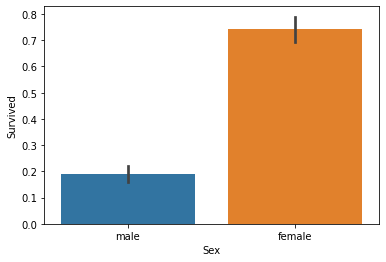

In [ ]:
# 시각화를 통해 직관적으로 확인

sns.barplot(x='Sex', y='Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

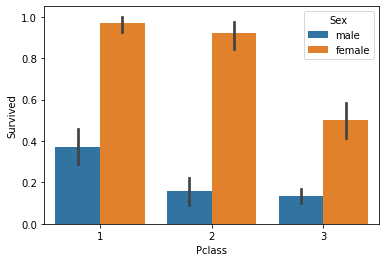

In [ ]:
# 2) 선실 등급 - 생존 상관관계

sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

In [ ]:
# 3) 나이에 따른 생존 상관관계
# 나이는 값 종류가 많으므로 범위(범주)별로 구분해서 파악

def get_category(age):
    category = ''
    if age <= -1 : category = 'Unknown'
    elif age <= 5 : category = 'Baby'
    elif age <= 12 : category = 'Child'
    elif age <= 18 : category = 'Teenager'
    elif age <= 25 : category = 'Student'
    elif age <= 35 : category = 'Young Adult'
    elif age <= 60 : category = 'Adult'
    else : category = 'Elderly'
    return category

In [ ]:
# x축 label

group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']
titanic_df['Age_Category'] = titanic_df['Age'].apply(lambda x : get_category(x))

<AxesSubplot:xlabel='Age_Category', ylabel='Survived'>

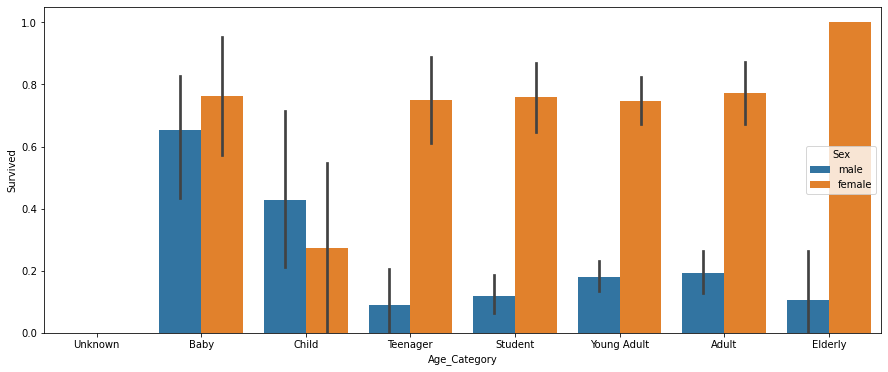

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x='Age_Category', y='Survived', hue='Sex', data=titanic_df, order=group_names)

### 데이터 전처리 - 필요없는 카테고리 삭제

In [ ]:
from sklearn.preprocessing import LabelEncoder

# null 처리
def fillna(df):
    titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
    titanic_df['Cabin'].fillna('N', inplace=True)         # Cabin 컬럼의 NaN값을 'N'문자로 채움
    titanic_df['Embarked'].fillna('N', inplace=True)
    return df

# 필요없는 카테고리 제거
def drop_feature(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩
def encoding_features(df):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 최종 전처리 수행 함수
def transform_features(df):
    df = fillna(df)
    df = drop_feature(df)
    df = encoding_features(df)
    return df
    

In [ ]:
# 전처리를 한번에 하는 함수를 이용해서 원본 데이터를 다시 로딩 - 전처리 수행
titanic_df = pd.read_csv('data/titanic_train.csv')

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

# 학습한 train 세트를 전처리
X_titanic_df = transform_features(X_titanic_df)
X_titanic_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,147,2
1,1,0,38.0,1,0,71.2833,81,0
2,3,0,26.0,0,0,7.9250,147,2
3,1,0,35.0,1,0,53.1000,55,2
4,3,1,35.0,0,0,8.0500,147,2


### 모델 학습

In [ ]:
# 학습 세트와 테스트 세트로 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [ ]:
# 예측시 많이 사용하는 알고리즘 3가지로 예측시키기

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(random_state=11)

# [실습]
# 각 알고리즘 별로 학습 - 예측 - 정확도 평가 해보기 